# Trotterized time evolution in the (1,2,1) Hamiltonian

Begin with an implementation of a Trotterization of the time evolution operator $U(t',t)$ that is not yet decomposed into gates.

### Schrodinger picture

In Schrodinger picture, the time evolution operator is simply $\exp(-i H t)$. This is first Trotterized in time to become

$$ \exp(-i H t) = \bigg[ \exp(-i H_E t / N) \exp(-i H_B t / N) \bigg]^N + \mathcal{O}(t^2/N^2)$$

In [1]:
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt

### Helper functions for creating operators

In [ ]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Define functions that implements the operators in the Hamiltonian.
Want to work with sparse matrices.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

# Create the one-qubit operations
Id =  sparse.csc_matrix(np.array([[1.,0.],[0.,1.]]))
P1 = sparse.csc_matrix(np.array([[0., 0.],[0., 1.]]))
P0 = sparse.csc_matrix(np.array([[1.,0.],[0.,0.]]))
Xop = sparse.csc_matrix(np.array([[0.,1.],[1.,0.]]))
Yop = sparse.csc_matrix(np.array([[0.,-1.j],[1.j,0.]]))


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
A function that acts with a one-qubit operator on a specified qubit. So, it takes in a 2x2 matrix and spits out a 2^n x 2^n matrix.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def one_qubit_gate( M: sparse._csc.csc_matrix, p: int, n: int) -> sparse._csc.csc_matrix:
    if (M.shape != (2,2)):
        print('Warning: Expected M argument to be a 2x2 sparse matrix.')
    if ( p<0 or p>=n ):
        print(f'Warning: Expected p argument to be within the range [0, {n}-1] inclusive.')

    result = sparse.eye(1, format='csc') # create a sparse 1x1 matrix to store result
    for i in range(n):
        if (i==p):
            result = sparse.kron(result, M, format='csc')
        else:
            result =sparse.kron(result, Id, format='csc')  
    return result


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    Define a function that returns an n-qubit gate that is in the form of a tensor product of single qubit gates.

    Expects the dictionary op_dict to be of the form { p1: M1, p2: M2, p3: M3 } where the p's are integers specifying
    qubits and the M's are 2x2 matrices in sparse format specifying one-qubit gates.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def multi_qubit_gate( op_dict: dict, n: int) -> sparse._csc.csc_matrix:
    result = sparse.eye(1, format='csc') # Create a 1x1 in sparse format to build our operator
    for i in range(n):
        if i in op_dict:
            result =sparse.kron(result, op_dict[i], format='csc')
        else:
            result =sparse.kron(result, Id, format='csc')
    return result


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Convert between the single-index p which enumerates qubits, and double-index (i,j) which enumerates lattice sites
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def map_to_circuit( i, j, L, H ):
    if i >= L:
        print(f"[map_to_circuit] i index out of bounds: expected i<{L}, but i={i}")
    if j >= H:
        print(f"[map_to_circuit] j index out of bounds, expected j<{H}, but j={j}")
    
    return j*L + i


def map_to_lattice( p, L, H ):
    if p >= (L*H):
        print(f"[map_to_lattice] p index out of bounds, expected p<{L*H}, but p={p}")

    return p % L, p // L


def get_neighbours( p, lat_shape, boundary='periodic' ):
    L, H = lat_shape
    i, j = map_to_lattice(p, L, H)
    if boundary == 'periodic':
        nl   = map_to_circuit((i - 1) % L, j, L, H)
        nd   = map_to_circuit(i, (j - 1) % H, L, H)
        nr   = map_to_circuit((i + 1) % L, j, L, H)
        nu   = map_to_circuit(i, (j + 1) % H, L, H)
        return nl, nd, nr, nu
    elif boundary == 'open':
        if i == 0:
            nl = None
        else:
            nl = map_to_circuit(i - 1, j, L, H)
        if j == 0:
            nd = None
        else:
            nd = map_to_circuit(i, j - 1, L, H)
        if i == L - 1:
            nr = None
        else:
            nr = map_to_circuit(i + 1, j, L, H)
        if j == H - 1:
            nu = None
        else:
            nu = map_to_circuit(i, j + 1, L, H)
        return nl, nd, nr, nu


# A function that applies the specified operator to every qubit in the lattice, and then returns the resulting matrix
def sigma(op_name, lat_shape, boundary='periodic'):
    L = lat_shape[0]
    H = lat_shape[1]
    n = L*H

    op = sparse.csc_matrix((2**n, 2**n))

    if boundary == "periodic":

        if op_name == "P1":
            for p in range(n):
                op += one_qubit_gate(P1, p, n)

        elif op_name == "P1P1":
            for p in range(n):
                i, j = map_to_lattice(p, L, H)
                nr   = map_to_circuit((i + 1) % L, j, L, H)
                nu   = map_to_circuit(i, (j + 1) % H, L, H)
                op  = multi_qubit_gate( {p: P1, nr: P1}, n )
                op += multi_qubit_gate( {p: P1, nu: P1}, n )

        elif op_name == "P0P0P0P0X":
            for p in range(n):
                nl, nd, nr, nu = get_neighbours(p, lat_shape)
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P0, nu: P0}, n )

        elif op_name == "P0P0P0P1X":
            for p in range(n):
                nl, nd, nr, nu = get_neighbours(p, lat_shape)
                op += multi_qubit_gate( {p: Xop, nl: P1, nd: P0, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P1, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P1, nu: P0}, n )
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P0, nu: P1}, n )
        
        elif op_name == "P0P0P0P0Y":
            for p in range(n):
                nl, nd, nr, nu = get_neighbours(p, lat_shape)
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P0, nr: P0, nu: P0}, n )
        
        elif op_name == "P0P0P0P1Y":
            for p in range(n):
                nl, nd, nr, nu = get_neighbours(p, lat_shape)
                op += multi_qubit_gate( {p: Yop, nl: P1, nd: P0, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P1, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P0, nr: P1, nu: P0}, n )
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P0, nr: P0, nu: P1}, n )
        else:
            raise ValueError(f"Unknown operator name: {op_name}")
    
    elif boundary == "open":
        raise NotImplementedError("Open boundary conditions not implemented yet.")
    
    return op


### Code for making the Hamiltonian

In [3]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''' 
Create a function that produces the Hamiltonian matrix
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def make_electric_ham(g: float, lat_shape: list, boundary: str = 'periodic', N_colors: int = 3 ) -> sparse._csc.csc_matrix:
    H_E = sigma('P1', lat_shape, boundary)
    H_E -= 0.5 * sigma('P1P1', lat_shape, boundary)
    return (N_colors - 1/N_colors)*g*g * H_E


def make_magnetic_ham( g: float, lat_shape: tuple, boundary='periodic', N_colors: int = 3) -> sparse._csc.csc_matrix:
    coeff1 = -np.sqrt(2)/(2*g*g)
    coeff2 = -1/(2*g*g*N_colors)
    H_B1 = sigma('P0P0P0P0X', lat_shape, boundary)
    H_B2 = sigma('P0P0P0P1X', lat_shape, boundary)
    return coeff1 * H_B1  +   coeff2 * H_B2


def make_ham(g: float, lat_shape: tuple, boundary: str ='periodic', N_colors: int =3 ) -> sparse._csc.csc_matrix:
    HE = make_electric_ham(g, lat_shape, boundary, N_colors)
    HB = make_magnetic_ham(g, lat_shape, boundary, N_colors)
    return HE + HB


def get_ground_state_energy(g, lat_shape, boundary='periodic', N_colors=3):
    H = make_ham(g, lat_shape, boundary, N_colors)
    evals, evecs = sparse.linalg.eigsh( H, which='SA', k=1)
    return evals[0]

def get_ground_state(g, lat_shape, boundary='periodic', N_colors=3):
    H = make_ham(g, lat_shape, boundary, N_colors)
    _, evecs = sparse.linalg.eigsh( H, which='SA', k=1)
    return evecs[:,0] / np.linalg.norm(evecs[:,0]) # Normalize the ground state vector


## Direct exponentiation

In [4]:
def U_expm(H, t):
    """
    Compute the matrix exponential of H*t using scipy's expm function.
    """
    return sparse.linalg.expm(-1j * H * t)

In [72]:
g = 0.7
lat_shape = (3, 3)
boundary = 'periodic'
N_colors = 3

# Define the Hamiltonian
H = make_ham(g, lat_shape, boundary, N_colors)

# Get the ground state
ground_state = get_ground_state(g, lat_shape, boundary, N_colors)

def measure_single_qubit(psi, p, lat_shape, outcome=0):
    """
    Measure the state psi at position p in the lattice, and get the outcome as the result of the measurement.
    outcome = 0 or 1
    """
    L, H = lat_shape
    n = L * H
    if outcome == 0:
        psi_p = one_qubit_gate(P0, p, n) @ psi
        return ( psi_p ) / np.linalg.norm( psi_p )
    elif outcome == 1:
        psi_p = one_qubit_gate(P1, p, n) @ psi
        return ( psi_p ) / np.linalg.norm( psi_p )
    else:
        raise ValueError("Outcome must be either 0 or 1.")
    
def prob_0_single_qubit(psi, p, lat_shape):
    """
    Measure the probability of getting outcome 0 when measuring the state psi at position p in the lattice.
    """
    L, H = lat_shape
    psi = psi / np.linalg.norm(psi)
    return np.abs( np.vdot(psi, measure_single_qubit(psi, p, lat_shape, outcome=0)) )**2

def prob_0_all_qubits(psi, lat_shape):
    """
    Measure the probability of getting outcome 0 when measuring the state psi at all positions in the lattice.
    """
    L, H = lat_shape
    prob_0_arr = np.zeros(lat_shape)
    for i in range(L):
        for j in range(H):
            p = map_to_circuit(i, j, L, H)
            prob_0_arr[i, j] = prob_0_single_qubit(psi, p, lat_shape)
    return prob_0_arr

ground_state_p = measure_single_qubit(ground_state, 4, lat_shape, outcome=0)


prob_0_p = np.vdot(ground_state_p, ground_state)**2



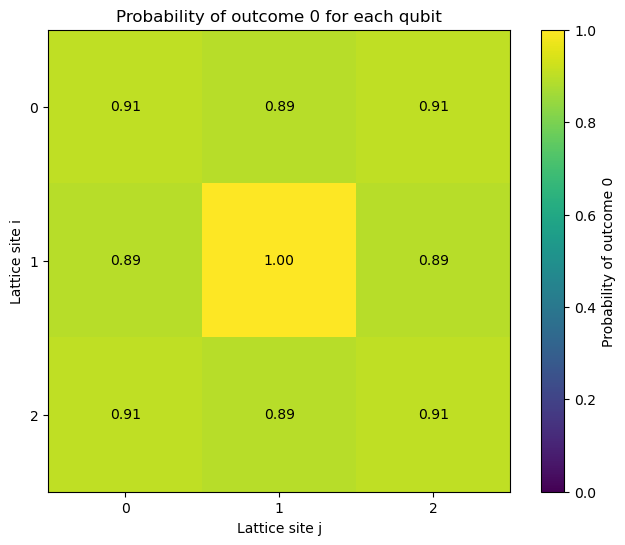

In [38]:
prob_0_arr = prob_0_all_qubits(ground_state_p, lat_shape)

# plot a heat map of the probabilities, with the color bar ranging from 0 to 1
# write the value of the probability at each point in the lattice
plt.figure(figsize=(8, 6))
plt.imshow(prob_0_arr, interpolation='nearest', vmin=0, vmax=1)
plt.colorbar(label='Probability of outcome 0')
plt.title('Probability of outcome 0 for each qubit')
plt.xlabel('Lattice site j')
plt.ylabel('Lattice site i')
plt.xticks(np.arange(lat_shape[1]), np.arange(lat_shape[1]))
plt.yticks(np.arange(lat_shape[0]), np.arange(lat_shape[0]))

for i in range(lat_shape[0]):
    for j in range(lat_shape[1]):
        p = map_to_circuit(i, j, lat_shape[0], lat_shape[1])
        plt.text(j, i, f'{prob_0_arr[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()



In [76]:
# time evolve the measured state, and plot the probability of getting outcome 0 at each time step
T = 3
dt = 0.03
tvals = np.arange(0, T, dt)

U_dt = U_expm(H, dt)
psi_t = np.zeros((len(tvals), 2**(lat_shape[0]*lat_shape[1])), dtype=complex)
psi_t[0] = ground_state_p
for i in range(1, len(tvals)):
    psi_t[i] = U_dt @ psi_t[i-1]
    #psi_t[i] /= np.linalg.norm(psi_t[i]) # Normalize the state at each time step



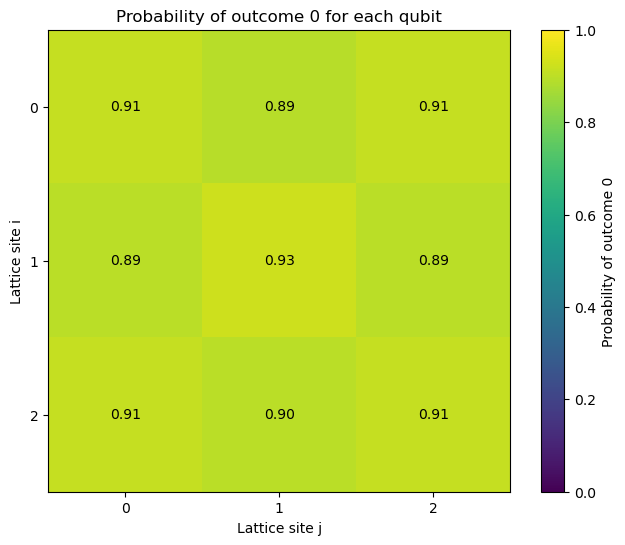

In [80]:
prob_0_arr = prob_0_all_qubits(psi_t[80], lat_shape)

# plot a heat map of the probabilities, with the color bar ranging from 0 to 1
# write the value of the probability at each point in the lattice
plt.figure(figsize=(8, 6))
plt.imshow(prob_0_arr, interpolation='nearest', vmin=0, vmax=1)
plt.colorbar(label='Probability of outcome 0')
plt.title('Probability of outcome 0 for each qubit')
plt.xlabel('Lattice site j')
plt.ylabel('Lattice site i')
plt.xticks(np.arange(lat_shape[1]), np.arange(lat_shape[1]))
plt.yticks(np.arange(lat_shape[0]), np.arange(lat_shape[0]))

for i in range(lat_shape[0]):
    for j in range(lat_shape[1]):
        p = map_to_circuit(i, j, lat_shape[0], lat_shape[1])
        plt.text(j, i, f'{prob_0_arr[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

In [77]:

for i, t in enumerate(tvals):
    prob_0_arr = prob_0_all_qubits(psi_t[i], lat_shape)
    # plot a heat map of the probabilities, with the color bar ranging from 0 to 1
    # write the value of the probability at each point in the lattice
    plt.figure(figsize=(8, 6))
    plt.imshow(prob_0_arr, interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar(label='Probability of outcome 0')
    plt.title(f'Probability of outcome 0 for each qubit at t={t:.2f}')
    plt.xlabel('Lattice site j')
    plt.ylabel('Lattice site i')
    plt.xticks(np.arange(lat_shape[1]), np.arange(lat_shape[1]))
    plt.yticks(np.arange(lat_shape[0]), np.arange(lat_shape[0]))

    for i in range(lat_shape[0]):
        for j in range(lat_shape[1]):
            p = map_to_circuit(i, j, lat_shape[0], lat_shape[1])
            plt.text(j, i, f'{prob_0_arr[i, j]:.2f}', ha='center', va='center', color='black')
    plt.savefig(f'prob_0_arr_t_{t:.2f}.jpg', dpi=300)
    plt.close()


array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

## Local trotterization

In addition to Trotterizing in time, we break up the exponential from a sum over sites, to a product of exponentials over sites.

Begin by breaking up the Hamiltonian's different terms:

$$ \exp\big( i t ( H_{E1} + H_{E2} + H_{B1} + H_{B2}) \big) \rightarrow \exp\big( i t ( H_{E1} + H_{E2} ) \big) \exp\big( i t (H_{B1} + H_{B2})  \big) + \mathcal{O}(t^2) $$

The electric and magnetic parts of the Hamiltonian do not commute, so we pick up an error proportional to their commutator.

For the electric part, the one and two-qubit operators all commute with each other, so with no error incurred we can write:

$$ \exp\bigg( i t ( \sum_p H_{E1,p} + H_{E2,p} ) \bigg) = \bigg[ \prod_p \exp(i t H_{E1, p}) \bigg] \bigg[ \prod_p \exp(i t H_{E2, p})\bigg]  $$

For the magnetic part, in general many of the 5-qubit operators do not commute with each other, but we can still break them up

$$ \exp\big( i t ( \sum_p H_{B1,p} + H_{B2,p}) \big) \rightarrow \bigg[ \prod_p \exp(i t H_{B1, p}) \bigg] \bigg[ \prod_p \exp(i t H_{B2, p})\bigg] + \mathcal{O}(t^2) $$

while incurring error of the same order as previously incurred when breaking up the magnetic and electric parts. Then the simplest way of breaking up the exponential is:

$$ \exp(- i H t) =  \bigg[ \prod_p \exp(- i t H_{E1, p}) \bigg] \bigg[ \prod_p \exp(- i t H_{E2, p})\bigg]\bigg[ \prod_p \exp(- i t H_{B1, p}) \bigg] \bigg[ \prod_p \exp(- i t H_{B2, p})\bigg] + \mathcal{O}(t^2) $$



In [143]:
theta = np.pi
RX1 = sparse.linalg.expm(-1j * theta * Xop / 2 )

RX2 = np.cos(theta/2)*Id + 1j*np.sin(theta/2)*Xop

( RX1 - RX2 < 0.00000000000001 ).toarray()

array([[ True,  True],
       [ True,  True]])

In [ ]:
def make_U_trotterized(t, lat_shape):
    L, H = lat_shape
    n = L*H

    # Compute the trotterized E1 operator
    U = sparse.eye(2**n, format="csc")
    for p in range(n):
        C = (N_colors - 1/N_colors)*g*g
        op = one_qubit_gate( sparse.linalg.expm(-1j * t * C * P1) , p, n )
        U = op @ U

     # Compute the trotterized E2 operator
    for p in range(n):
        i, j = map_to_lattice(p, L, H)
